# IMDB movies data Sentiment Analysis

### About Data

- Data Conteins 50000 texts

- 25000 text are positive

- 25000 text are negative

- 2 labels are there 'positive' ans 'negative'

## Collecting/Getting Data

#### Dependencies

In [2]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import ngrams
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords 
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Read Data from csv file
imdb_data = pd.read_csv("imdb.csv",encoding='ISO-8859-1')

## Explore and Clean Data

### 1 Explore and understand data 

In [4]:
imdb_data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
imdb_data.columns

Index(['review', 'sentiment'], dtype='object')

We don't need 'ItemID' column

In [6]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
#for counting ham and spam

imdb_data.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [8]:
imdb_data.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  Nickelodeon has gone down the toilet. They hav...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

### 2 Clean Data

In [9]:
imdb_data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

what is the problems:
- capital letters
- <br /> charecters
- ... or .... charecters
- 

In [10]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic ={ "isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def data_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [11]:
# imdb_data[imdb_data.isnull().any(axis=1)].head()

,review,sentiment


We don't have NaN data for now

In [12]:
# %%time
# print ("Cleaning the reviews...\n")
# clean_imdb_reviews = []
# for row in imdb_data.review:
#     clean_imdb_reviews.append(data_cleaner_updated(row))

Cleaning the reviews...

CPU times: user 35.8 s, sys: 366 ms, total: 36.2 s
Wall time: 36.3 s


In [13]:
# clean_imdb_reviews[0]

'one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pretty pict

In [14]:
# clean_df = pd.DataFrame(clean_imdb_reviews,columns=['review'])
# clean_df['sentiment'] = imdb_data.sentiment
# clean_df.to_csv('clean_imdb.csv',encoding='utf-8')

In [15]:
csv = 'clean_imdb.csv'
clean_imdb_data = pd.read_csv(csv,index_col=0)
clean_imdb_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,wonderful little production the filming techni...,positive
2,thought this was wonderful way to spend time o...,positive
3,basically there family where little boy jake t...,negative
4,petter mattei love in the time of money is vis...,positive
...,...,...
49995,thought this movie did down right good job it ...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,am catholic taught in parochial elementary sch...,negative
49998,going to have to disagree with the previous co...,negative


In [15]:
imdb_data[imdb_data.isnull().any(axis=1)]

,review,sentiment


In [16]:
np.sum(clean_imdb_data.isnull().any(axis=1))

0

In [17]:
clean_imdb_data.isnull().any(axis=0)

review       False
sentiment    False
dtype: bool

We don't have NaN data, we don't have to clean anything in our data

In [18]:
clean_imdb_data.dropna(inplace=True)
clean_imdb_data.reset_index(drop=True,inplace=True)
clean_imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [19]:
np.sum(clean_imdb_data.isnull().any(axis=1))

0

## Data Visualition

Text(0.5,1,'Distribution of Positive and Negative')

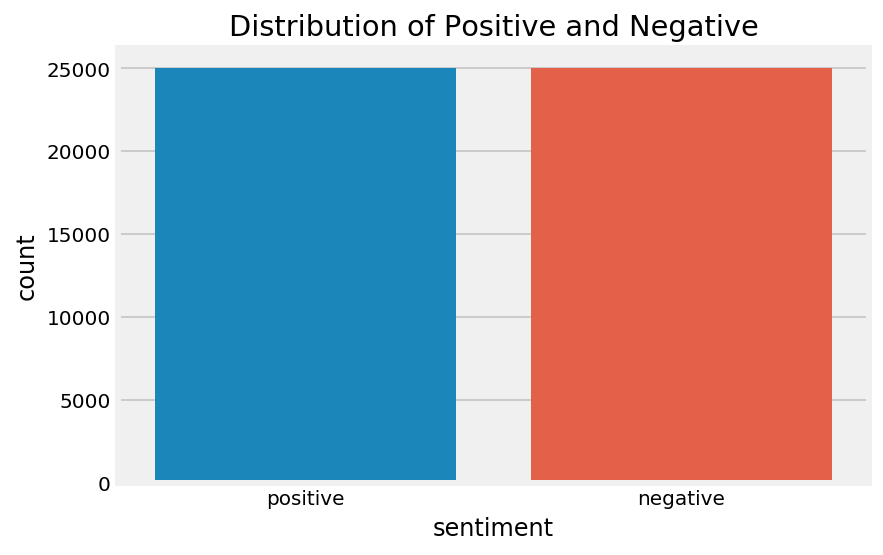

In [20]:
#plotting graph for distribution

sns.countplot(x = "sentiment", data = clean_imdb_data)
clean_imdb_data.loc[:,'sentiment'].value_counts()
plt.title('Distribution of Positive and Negative')

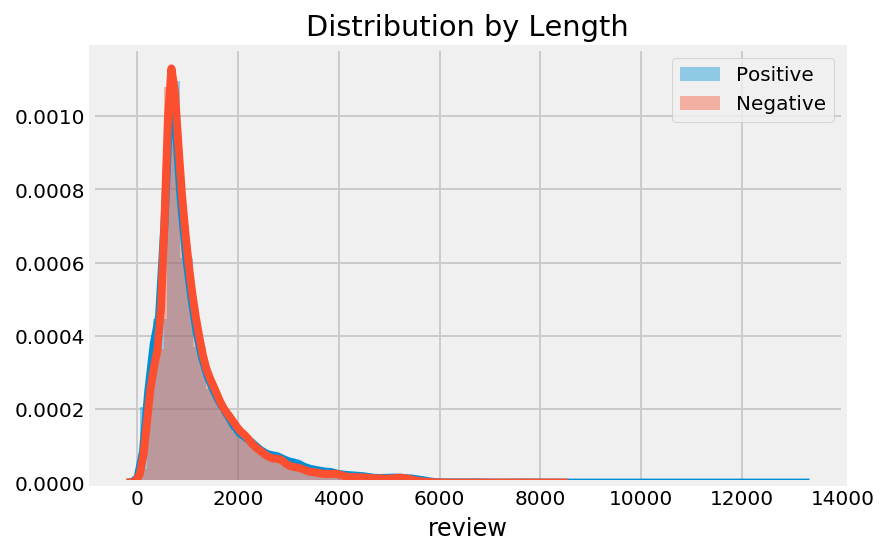

In [21]:
# plotting graph by length.

pos =clean_imdb_data[clean_imdb_data['sentiment'] == 'positive']['review'].str.len()
sns.distplot(pos, label='Positive')
neg = clean_imdb_data[clean_imdb_data['sentiment'] == 'negative']['review'].str.len()
sns.distplot(neg, label='Negative')
plt.title('Distribution by Length')
plt.legend()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


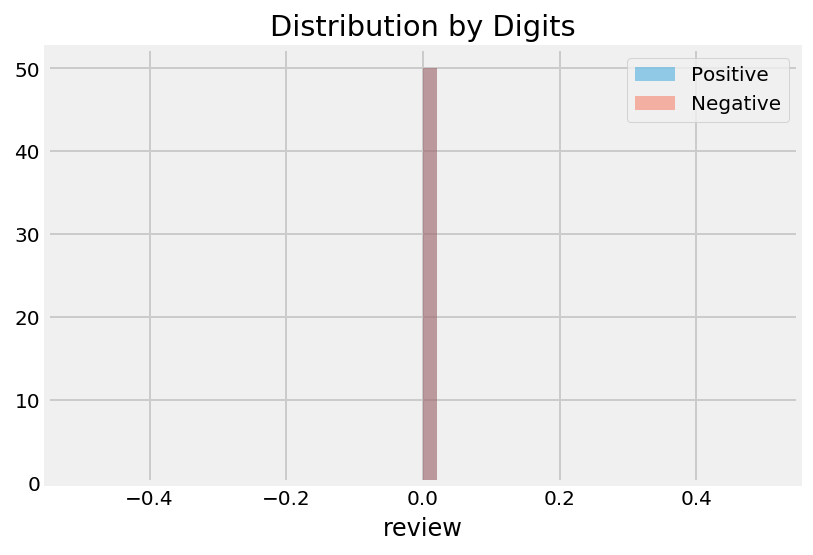

In [22]:
#plotting graph by digits.

pos1 = clean_imdb_data[clean_imdb_data['sentiment'] == 'positive' ]['review'].str.replace(r'\D+', '').str.len()
sns.distplot(pos1, label='Positive')
neg1 = clean_imdb_data[clean_imdb_data['sentiment'] == 'negative' ]['review'].str.replace(r'\D+', '').str.len()
sns.distplot(neg1, label='Negative')
plt.title('Distribution by Digits')
plt.legend()

This result means we don't have any digit data.

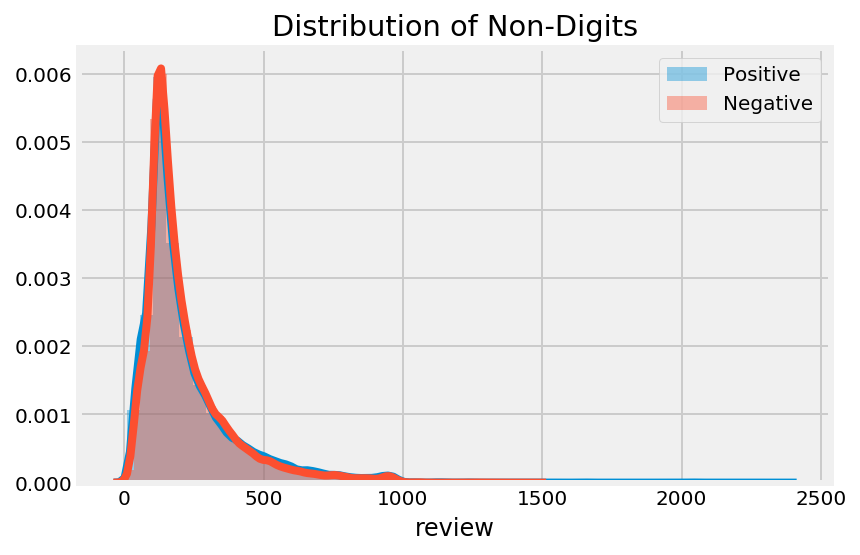

In [23]:
#plotting graph for non-digits.

pos2 = clean_imdb_data[clean_imdb_data['sentiment'] == 'positive']['review'].str.replace(r'\w+', '').str.len()
sns.distplot(pos2, label='Positive')
neg2 = clean_imdb_data[clean_imdb_data['sentiment'] == 'negative']['review'].str.replace(r'\w+', '').str.len()
sns.distplot(neg2, label='Negative')
plt.title('Distribution of Non-Digits')
plt.legend()

In [24]:
from collections import Counter
#for counting frequently occurence of pos and neg.

count1 = Counter(" ".join(clean_imdb_data[clean_imdb_data['sentiment']== 'positive']["review"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of pos", 'positive' : "count"})
count2 = Counter(" ".join(clean_imdb_data[clean_imdb_data['sentiment']== 'negative']["review"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of neg", 'negative' : "count_"})

#### Graph for top 30 words of positive

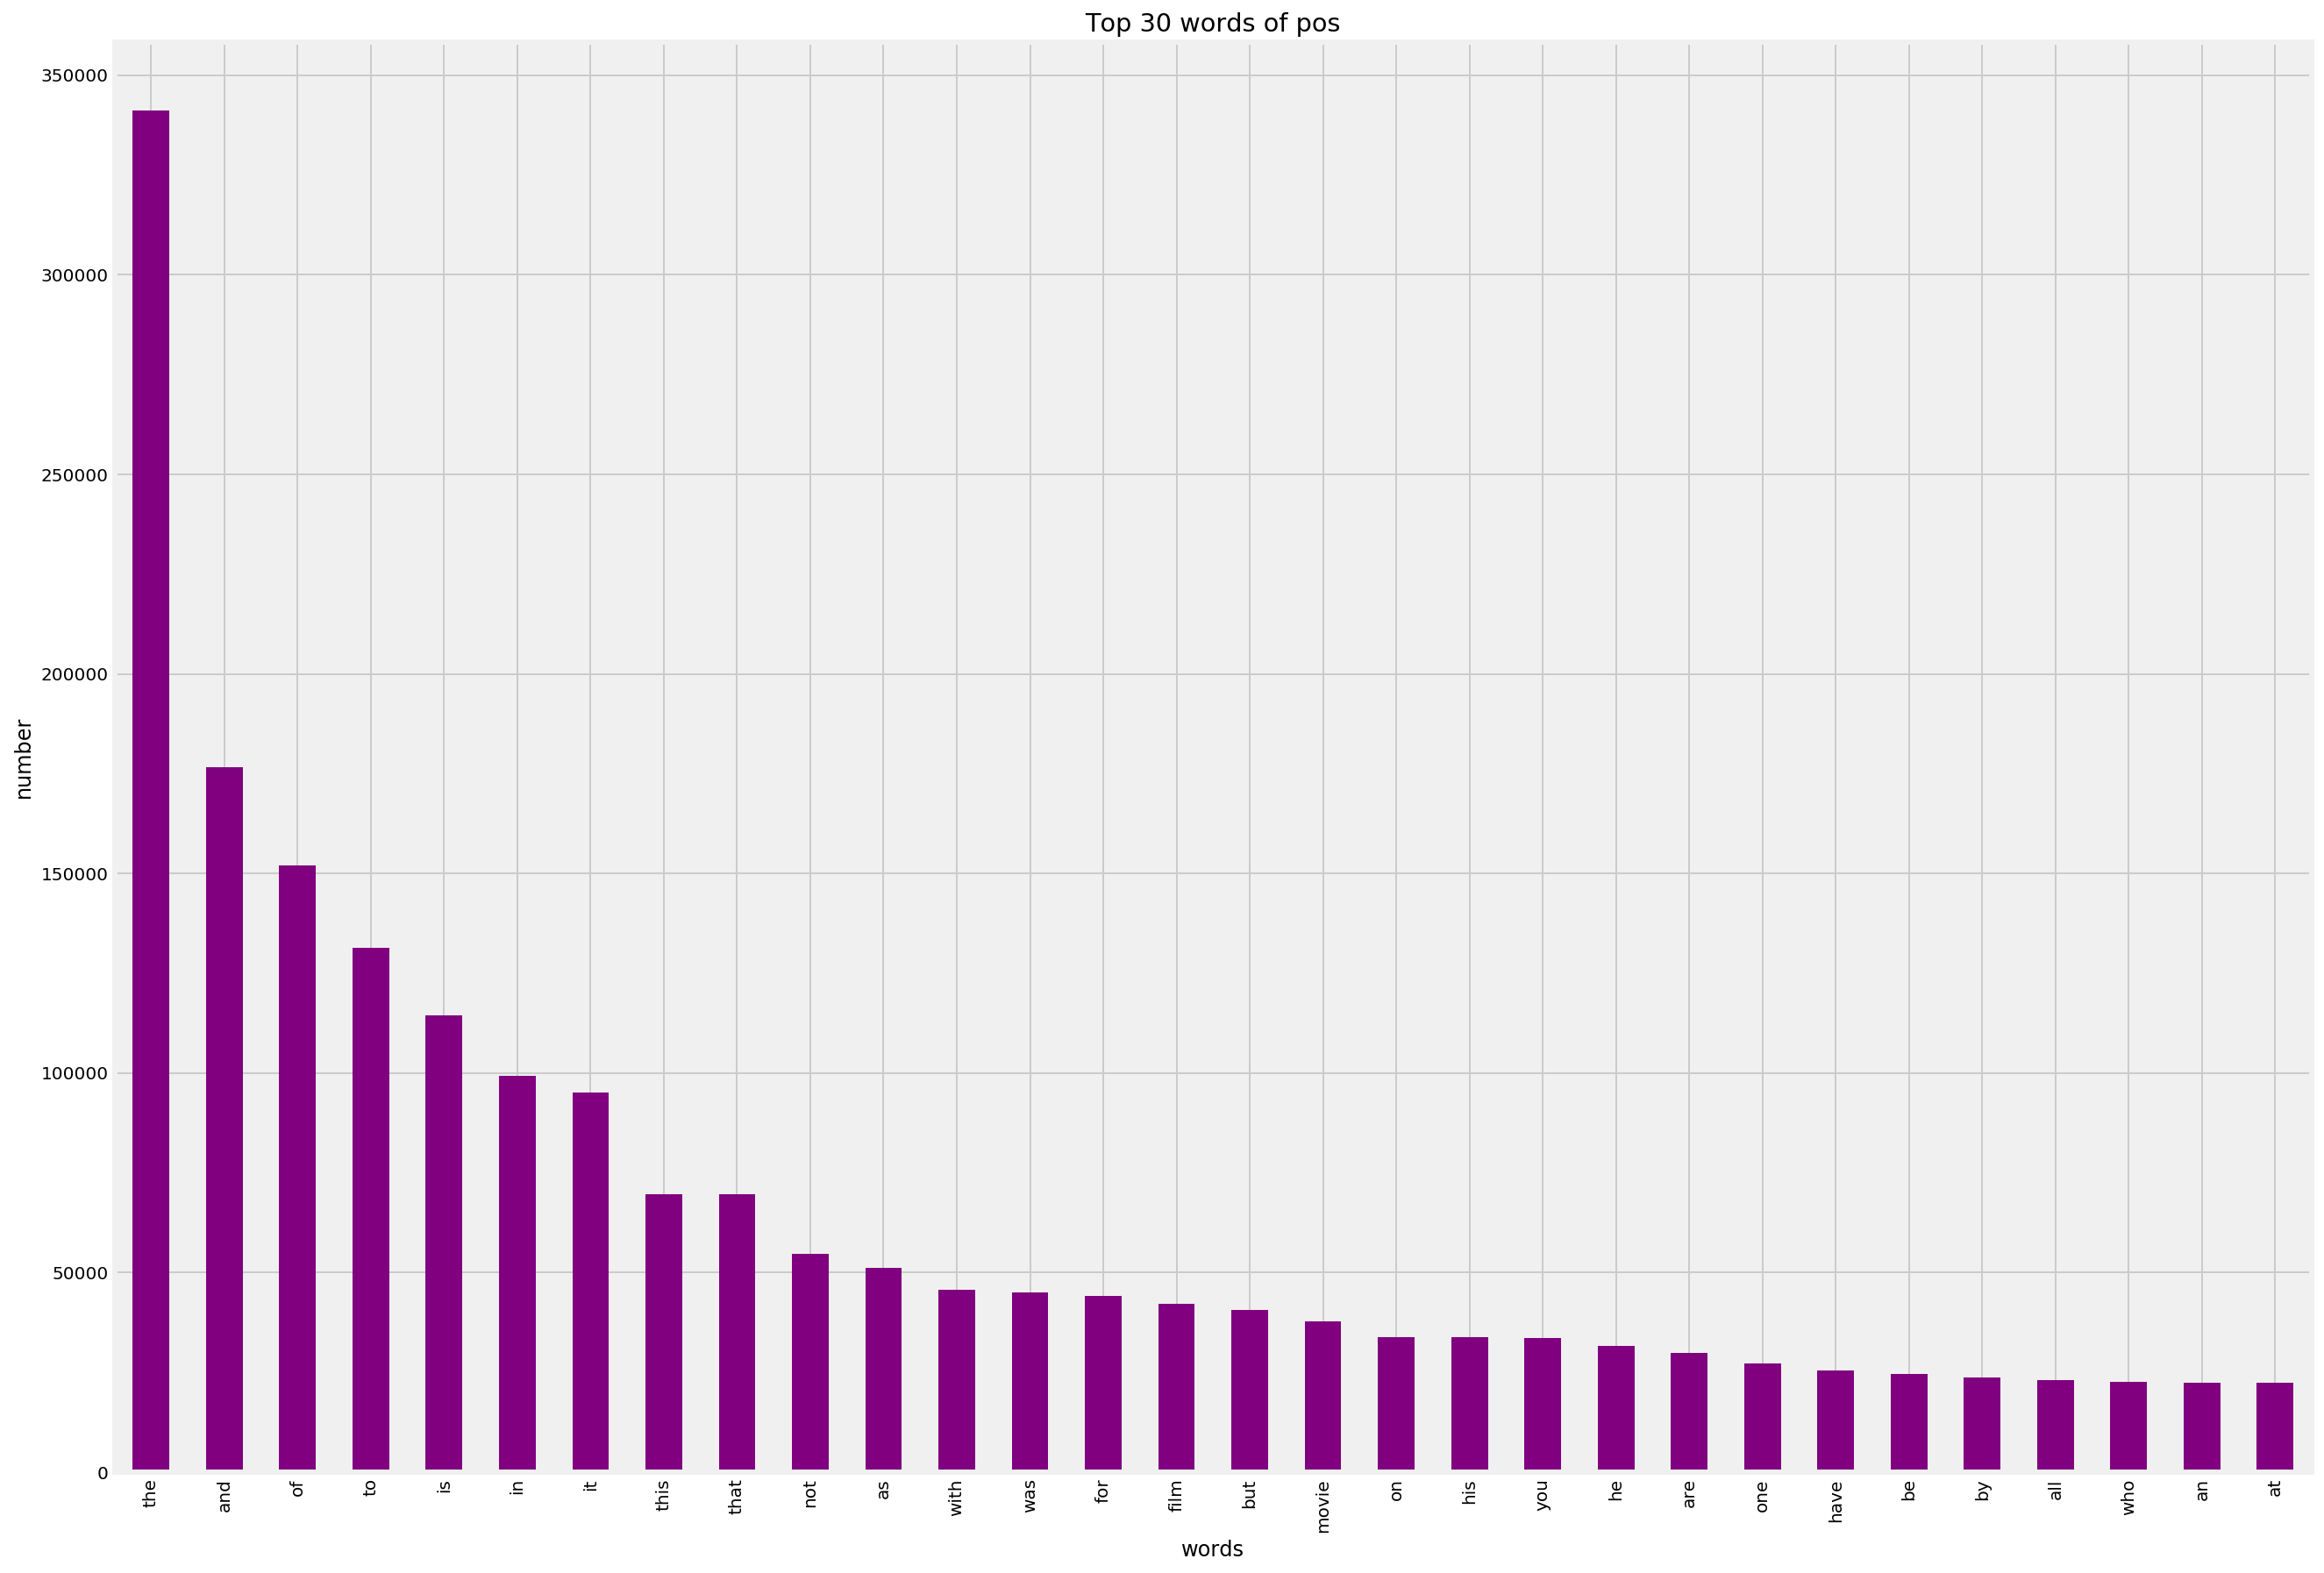

In [25]:
data1.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_pos = np.arange(len(data1["words of pos"]))
plt.xticks(y_pos, data1["words of pos"])
plt.title('Top 30 words of pos')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

#### Graph for top 30 words of negative

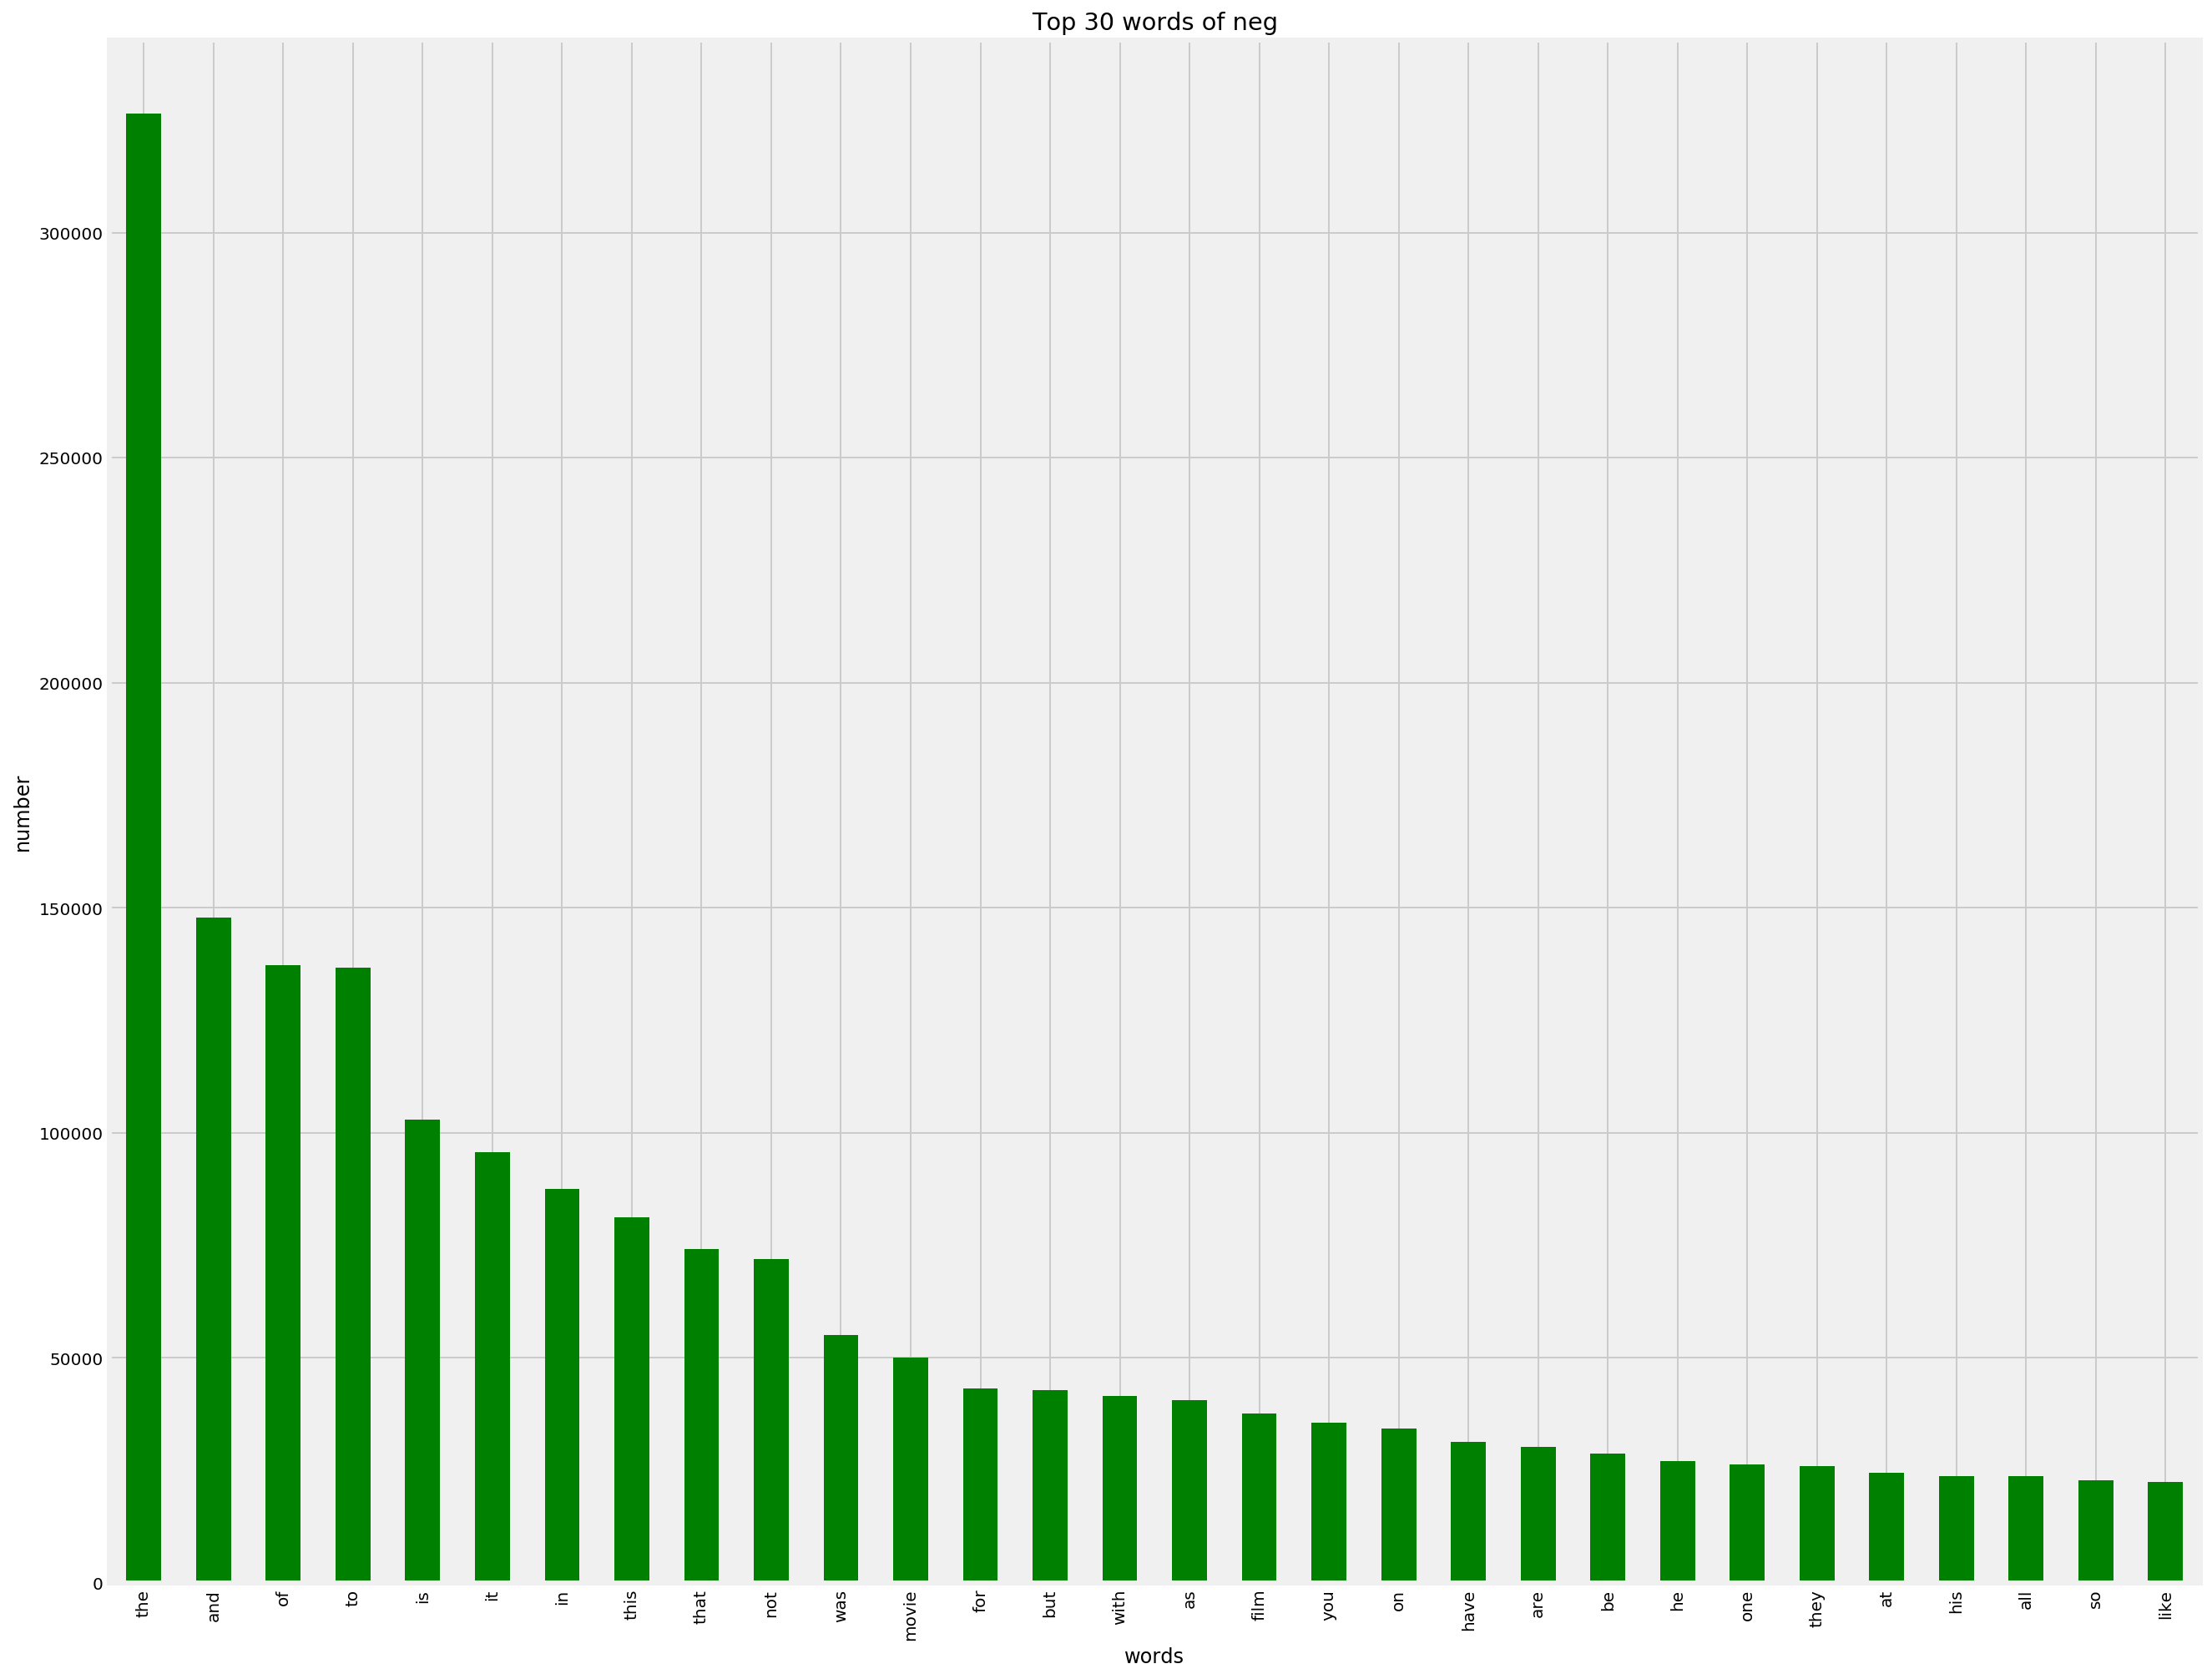

In [26]:
data2.plot.bar(legend = False, color = 'green', figsize = (20,17))
y_pos = np.arange(len(data2["words of neg"]))
plt.xticks(y_pos, data2["words of neg"])
plt.title('Top 30 words of neg')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### Word Cloud
#### 1 word Cloud for negative strings

In [27]:
neg_reviews = clean_imdb_data[clean_imdb_data.sentiment == 'negative']

neg_string = []
for t in neg_reviews.review:
    neg_string.append(t)
# neg_string
neg_string = pd.Series(neg_string).str.cat(sep=' ')
# neg_string

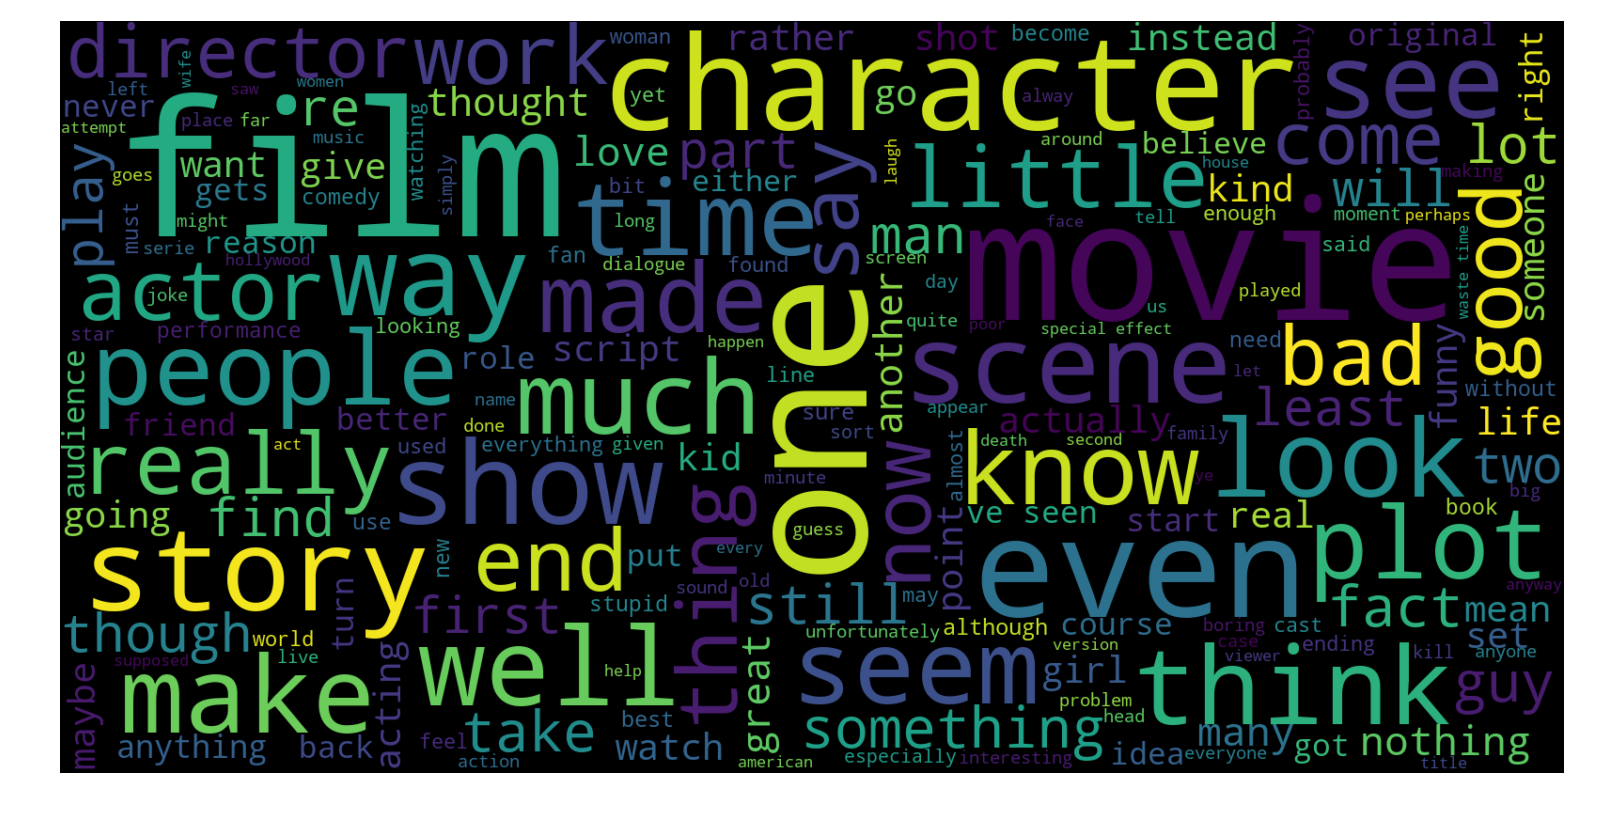

In [28]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### 2 word Cloud for positive strings

In [29]:
pos_reviews = clean_imdb_data[clean_imdb_data.sentiment == 'positive']
pos_string = []
for t in pos_reviews.review:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

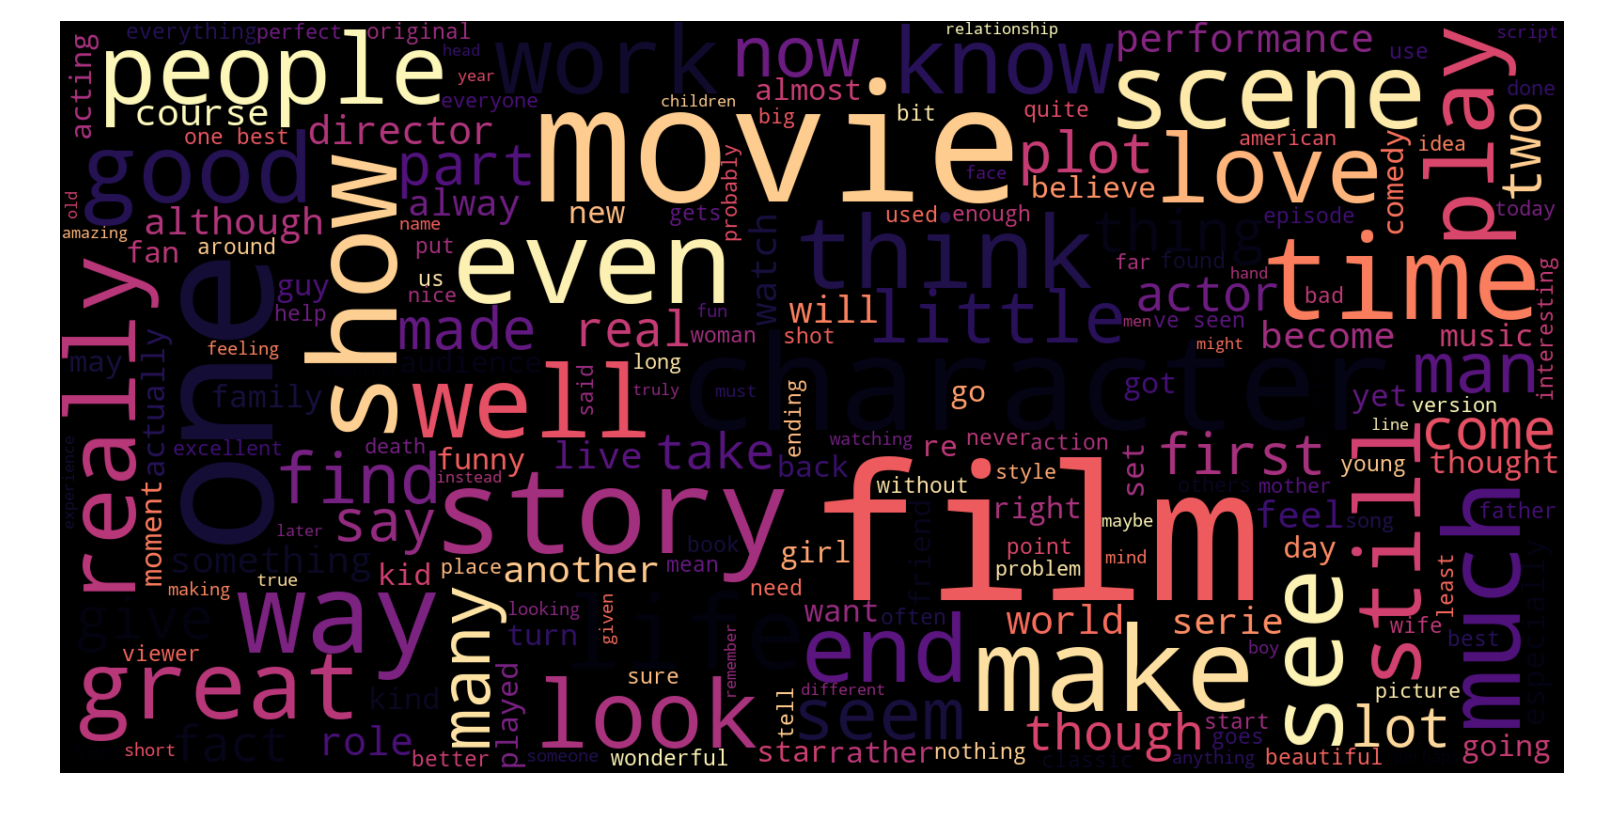

In [30]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### 3 word Cloud for all strings

In [31]:
all_string = []
for t in clean_imdb_data.review:
    all_string.append(t)
all_string = pd.Series(all_string).str.cat(sep=' ')

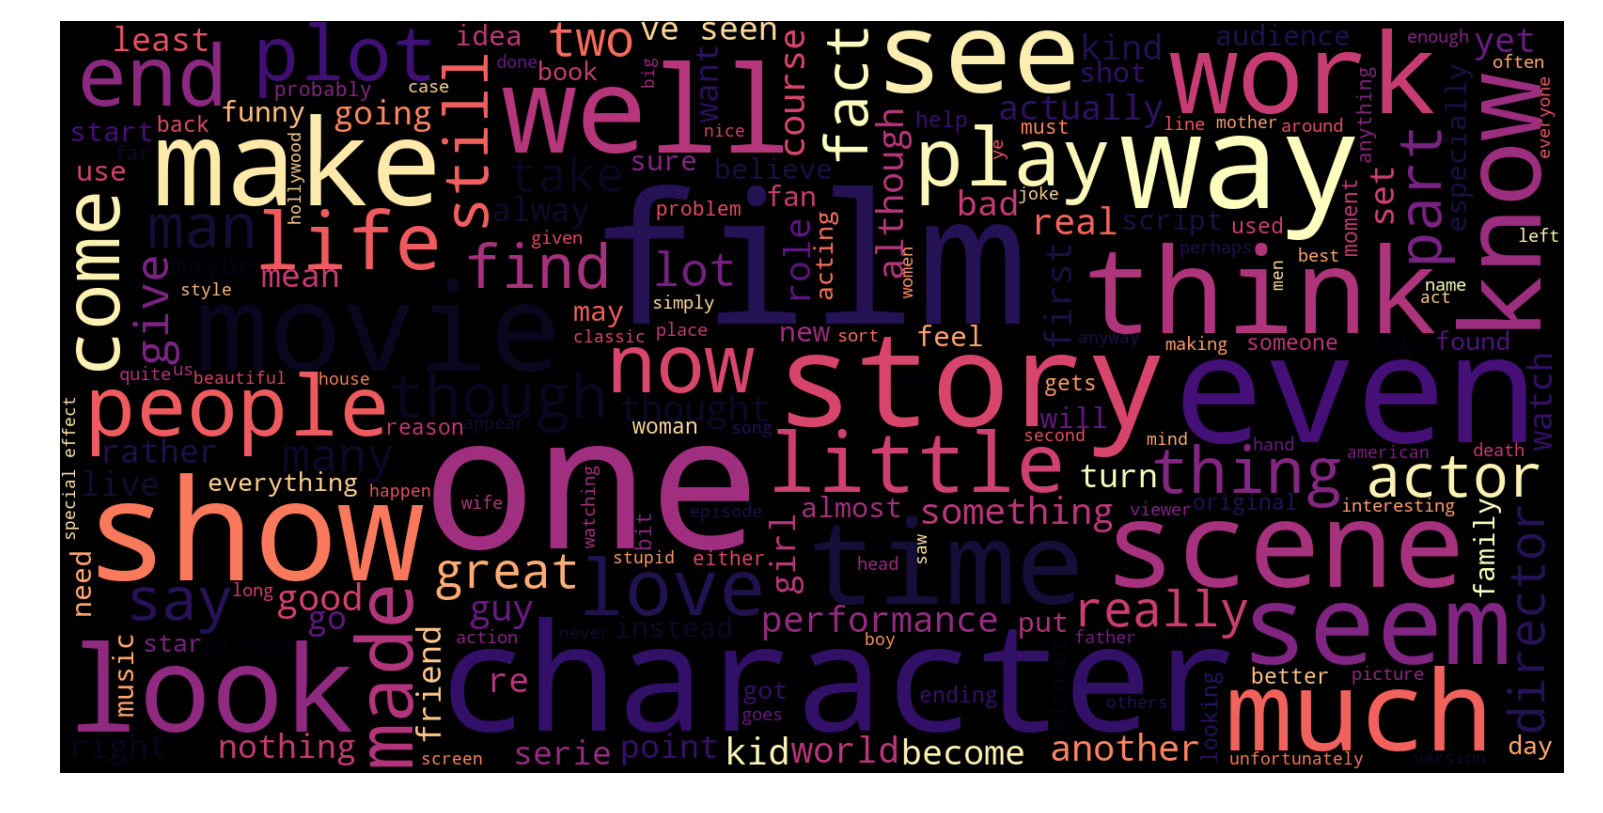

In [32]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(all_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
del pos_reviews, pos_string, neg_reviews, neg_string, wordcloud, all_string

# Models

## splitting the tweets data into train and test sets

In [34]:
clean_imdb_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,wonderful little production the filming techni...,positive
2,thought this was wonderful way to spend time o...,positive
3,basically there family where little boy jake t...,negative
4,petter mattei love in the time of money is vis...,positive
...,...,...
49995,thought this movie did down right good job it ...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,am catholic taught in parochial elementary sch...,negative
49998,going to have to disagree with the previous co...,negative


In [35]:
X_train, X_test, y_train, y_test = train_test_split(clean_imdb_data['review'], clean_imdb_data['sentiment'], test_size = 0.3, random_state = 37)
print ("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

X_train:  35000
X_test:  15000
y_train:  35000
y_test:  15000


# Countvectorizer

In [36]:
cv = CountVectorizer(binary=True, ngram_range=(1,2))
cv.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [37]:
X_train_cv = cv.transform(X_train)
X_train_cv

<35000x1899907 sparse matrix of type '<class 'numpy.int64'>'
	with 11991291 stored elements in Compressed Sparse Row format>

In [38]:
X_test_cv = cv.transform(X_test)
X_test_cv

<15000x1899907 sparse matrix of type '<class 'numpy.int64'>'
	with 4566838 stored elements in Compressed Sparse Row format>

## MultiNominal Naive Bayes

In [39]:
%%time
mnb = MultinomialNB(alpha = 0.5)
MNB_model = mnb.fit(X_train_cv,y_train)

y_mnb = mnb.predict(X_test_cv)

CPU times: user 664 ms, sys: 146 ms, total: 810 ms
Wall time: 674 ms


In [40]:
print('Naive Bayes Accuracy: ', accuracy_score(y_mnb , y_test))
print('Naive Bayes confusion_matrix:\n', confusion_matrix(y_mnb, y_test))
MNB_accuracy_train  = round(MNB_model.score(X_test_cv,y_test) * 100, 2)
MNB_accuracy_train 

Naive Bayes Accuracy:  0.8899333333333334
Naive Bayes confusion_matrix:
 [[6811  945]
 [ 706 6538]]


88.99

## Logistic Reg

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
%%time
# for c in [0.01, 0.05, 0.25, 0.5, 1]:
log_model = LogisticRegression(C=0.25)
LRC_model = log_model.fit(X_train_cv,y_train)
y_lr = log_model.predict(X_test_cv)
print('LR Accuracy_score: ',accuracy_score(y_test,y_lr))
print('LR confusion_matrix: ', confusion_matrix(y_lr, y_test)) 
LRC_accuracy_train  = round(LRC_model.score(X_test_cv,y_test) * 100, 2)
LRC_accuracy_train

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy_score:  0.9088666666666667
LR confusion_matrix:  [[6779  629]
 [ 738 6854]]
CPU times: user 43.2 s, sys: 3.38 s, total: 46.6 s
Wall time: 32.6 s


90.89

In [43]:
print('LR Accuracy_score: ',accuracy_score(y_test,y_lr))
print('LR confusion_matrix: ', confusion_matrix(y_lr, y_test)) 
LRC_accuracy_train  = round(LRC_model.score(X_test_cv,y_test) * 100, 2)
LRC_accuracy_train

LR Accuracy_score:  0.9088666666666667
LR confusion_matrix:  [[6779  629]
 [ 738 6854]]


90.89

# TF-IDF

In the bag of words approach, each word has the same weight. The idea behind the TF-IDF approach is that the words that occur less in all the documents and more in individual document contribute more towards classification.

TF-IDF is a combination of two terms. Term frequency and Inverse Document frequency. They can be calculated as:

TF  = (Frequency of a word in the document)/(Total words in the document)

IDF = Log((Total number of docs)/(Number of docs containing the word))

In [44]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(clean_imdb_data.review).toarray()
processed_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, clean_imdb_data['sentiment'], test_size=0.3, random_state=0)

## LOG REG

In [46]:
%%time
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    log_model = LogisticRegression(C=c)
    LRC_model = log_model.fit(X_train,y_train)
    y_lr = log_model.predict(X_test)
    print('LR Accuracy_score: ',accuracy_score(y_test,y_lr))
    print('LR confusion_matrix: ', confusion_matrix(y_lr, y_test)) 
    LRC_accuracy_train  = round(LRC_model.score(X_test,y_test) * 100, 2)
    LRC_accuracy_train

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy_score:  0.8329333333333333
LR confusion_matrix:  [[5988  954]
 [1552 6506]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy_score:  0.8554
LR confusion_matrix:  [[6264  893]
 [1276 6567]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy_score:  0.874
LR confusion_matrix:  [[6467  817]
 [1073 6643]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy_score:  0.8784666666666666
LR confusion_matrix:  [[6519  802]
 [1021 6658]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy_score:  0.8814
LR confusion_matrix:  [[6556  795]
 [ 984 6665]]
CPU times: user 6.22 s, sys: 1 s, total: 7.22 s
Wall time: 8.69 s


## MN NAIVE BAYES

In [47]:
%%time
mnb = MultinomialNB(alpha = 0.5)
MNB_model = mnb.fit(X_train, y_train)

CPU times: user 574 ms, sys: 81.7 ms, total: 655 ms
Wall time: 459 ms


In [48]:
predictions = MNB_model.predict(X_test)

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[6313 1227]
 [ 978 6482]]
              precision    recall  f1-score   support

    negative       0.87      0.84      0.85      7540
    positive       0.84      0.87      0.85      7460

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000

0.853


# Sentiment Analysis Model

# CLASSIFY DATA

- Devide Data (bas every row is so long, mean Len is 1299)  
70 percent
- more cleaning +

## BOW
- Every word is converted into a feature using a simplified bag of words model 
86 percent

## MN Bayes

### Word Counts

- Vectorization:CountVectorizer(max_fetures:1500)
82 percent

- Vectorization:CountVectorizer(max_fetures:10000)
84 percent

- Vectorization:CountVectorizer(binary=True)
85.70 percent

- Vectorization:CountVectorizer(binary=True, ngram_range=(1,2))
89 percent

- Vectorization:CountVectorizer(binary=True, ngram_range=(1,3))
89.6 percent

### TF-IDF

- TF-IDF: (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
85 percent
 
- Vectorization: TF-IDF: (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'), ngram_range=(1,2))
85 percent


## LR MODEL

### Word Counts

- Vectorization:CountVectorizer(max_fetures:10000)
89 percent

- LogisticRegression(C=0.05) with Vectorization:CountVectorizer(binary=True)
89.2 percent

- LogisticRegression(C=0.25) with Vectorization:CountVectorizer(binary=True, ngram_range=(1,2)) 
91 percent

- LogisticRegression(C=0.25) with Vectorization:CountVectorizer(binary=True, ngram_range=(1,3)) 
90.7 percent

### TF-IDF
- LogisticRegression(C=1) with TF-IDF: (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'), ngram_range=(1,2))
88 percent

- LogisticRegression(C=1) with TF-IDF: (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
88 percent


